## Recreate DQN model from Deepmind Atari paper

This implementation mostly follows the paper **Playing Atari with Deep Reinforcement Learning**
[arXiv:1312.5602](https://arxiv.org/pdf/1312.5602.pdf)    
But also introduces some changes to improve learning stability:
- The use of target model (introduced in 2015 Nature paper) - a separate model used for computing target value, its parameters is fixed for a few steps before updated with parameters from the learning DQN model
- Adam optimizer instead of RMSProp 
- Use Huber loss instead of MSE

### Import dependencies

In [2]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to alleviate the problems of correlated data and non-stationary distributions

In [3]:
# This section was respecfully borrowed from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [10]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) 
                                                                        # **2 (for 2 sides of img) * out_channel
        
        dim_size = (((84-8)/4 + 1)-4)/2 + 1 #calculate size (of 1 side) of img after 2 convo layers
        self.layer3 = nn.Linear(int(dim_size)**2 * 32, 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x
    
print(model)

DQN_model(
  (layer1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (layer2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (layer3): Linear(in_features=2592, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=4, bias=True)
)


### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by **cropping an 84 × 84 region** of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, apply a custom **AtariCropping** wrapper, and a **ResizeObservation** wrapper

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Additionally, a **RescaleRange** wrapper is applied to normalize input value range from 0-255 to 0-1

State shape:  (4, 84, 84, 1)
Info  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


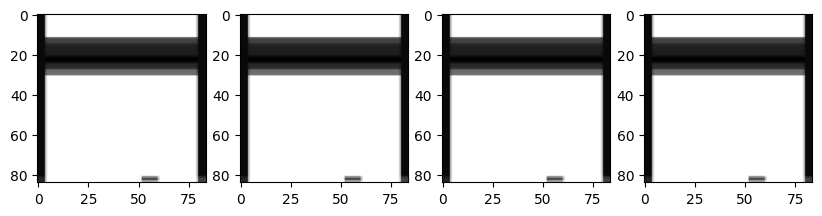

Low value 0.0 - High value 0.5803921818733215


In [14]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation
from utilities.custom_wrappers import ClipReward, AtariCropping, RescaleRange, MaxAndSkipEnv
# Many (if not all) custom wrappers were respecfully borrowed from stablebaselines wrappers and modified

def generate_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env, skip=4)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    env = RescaleRange(env)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("BreakoutNoFrameskip-v4") 
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())

print("State shape: ", np.asarray(observation).shape)
print("Info ", info)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap="binary")
plt.show()

print(f"Low value {np.min(np.asarray(observation))} - High value {np.max(np.asarray(observation))}")

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [12]:
import random

def choose_action(model, state, device, epsilon=0.001):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
        with torch.no_grad():
    #         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
            state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
            # predict
            pred = model(state)
            action = torch.argmax(pred.squeeze()).item()
            return int(action)

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights/params of model, $θ_i$ refers to model at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$) in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

To improve stability, **Huber loss** is used to mitigate gradient explosion and vanishing instead of MSE suggested by the original paper. It also effectively have the same effect as clipping error term that was introduced in the 2015 version of DQN paper. 

In [13]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
#     loss = (expected_qs-old_qs).pow(2).mean()
    
    # improvement for stability - use different loss 
    loss_func = nn.HuberLoss()
    loss = loss_func(old_qs, expected_qs)
    
    return loss

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward per episode** 

In [7]:
def eval_model(model, env_id, eval_steps=10000, device="mps"):
    env=generate_env(env_id)
    curr_state = env.reset()
    curr_state = np.asarray(curr_state)    
    episode_rewards = [0]
    
    for _ in range(eval_steps):
        action = choose_action(model, curr_state, device, epsilon=0.05)
        
        observation, reward, done, info = env.step(action)
        observation = np.asarray(observation) #convert to np array
        
        episode_rewards[-1]+=reward 
        curr_state = observation
        
        if done:
            # end of episode -> reset env, create new total reward for episode
            curr_state = env.reset()
            curr_state = np.asarray(curr_state)
            episode_rewards.append(0)
            
    # calculate mean episode, exclude last ep as it would be unfinished
    episode_reward = np.array(episode_rewards[:-1] if len(episode_rewards)>1 else episode_rewards)
    return np.mean(episode_reward)

### Parameters

In [15]:
# ------- Set up parameters -------
ENV = "BreakoutNoFrameskip-v4"
LOG_FREQ = 20 #number of EPISODES in-between logging results 
EVAL_FREQ = 50000 #number of STEPS before evaluate model
CHECKPOINT_FREQ = 500000 #number of STEPS before saving model
SAVE_DIR = "BreakoutFinal" #directory to save stuffs

# ------ Hyper parameters ---------
LEARNING_RATE = 0.000025
REPLAY_LEN = 100000 # 1000000 in paper, but I still like mah laptop, so no
BATCH_SIZE = 32
EPISODES = 20000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=True # whether to have target model or not
UPDATE_TARGET=10000 #steps to run before updating the target model
INITIAL_BUFFER_LEN=1000 # numbers of memory to populate buffer before training

### Setting up variables before training

In [16]:
# ------- Set up device, check for mps, cuda or cpu -----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ------- Set up env ----------------
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# ------- Set up model ----------------
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# ------- Set up optimizer ----------------
# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------- Set up stats tracker ----------------
steps = 0 # no. of steps
highest_reward = 0 # highest evaluation reward
epsilon = 1

# ------- Set up replay buffer ----------------
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
prev_lives = 0 # keep track of previous life
for i in range(INITIAL_BUFFER_LEN):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # penalize losing life
    reward = np.float64(-1) if (info['lives'] < prev_lives) else reward
    
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, done)
        
    # update curr state
    curr_state = observation
    prev_lives = info['lives']
    
    if done:
        curr_state = env.reset()
        curr_state = np.asarray(curr_state)
        prev_lives = 0
print(f"Initial length of replay memory: {len(replay_memory)}")

# ------- Set up saving dir ----------------
sub_folders = ["checkpoints", "tensorboard_runs"] # list of subfolders
for sub_folder in sub_folders:
    path = f"{SAVE_DIR}/{sub_folder}/"
    if not os.path.exists(path):
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"{path} created")
        
# ------- Set up Tensorboard --------------
sample_input = replay_memory.sample(32)
#     Transpose 
sample_input = Experience(*zip(*sample_input))
#     convert to a single np.array for faster tensor conversion
sample_state = np.array(sample_input.state)
# Tensor-ify state, action, reward, successor, done
sample_state = torch.Tensor(sample_state).squeeze().to(device)

writer = SummaryWriter(log_dir=f"{SAVE_DIR}/tensorboard_runs/")
writer.add_graph(model, sample_state) # add graph for model

print(f'Start Tensorboard by running this command from project folder: tensorboard --logdir="{SAVE_DIR}/tensorboard_runs"')

Device: mps
Current Atari environment: BreakoutNoFrameskip-v4
Learning rate: 5e-05
Initial length of replay memory: 1000
BreakoutFinal/checkpoints/ created
BreakoutFinal/tensorboard_runs/ created
Start Tensorboard by running this command from project folder: tensorboard --logdir="BreakoutFinal/tensorboard_runs"


### DQN training algorithm
<img src="./assets/dqn_algorithm.png" width=700>

Some additional steps:
- Keep track of current lives count to punish model when lose lives
- Update target model every set steps

In [10]:
with tqdm(total=EPISODES, unit="eps") as pbar:
    # main training loop
    for i in range(EPISODES):
        curr_state = env.reset()
        curr_state = np.asarray(curr_state) #convert to np array
        loss_val = 0 # loss value for curr episode
        reward_val = 0 # reward value for curr episode
        prev_lives = 0
        
        while True:
        # ---------- Epsilon decay logic ------------
            # decay over the first million frames then stay at 0.1
            decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
            epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
            
        # ---------- Training steps logic ------------
            # select and execute action [Step 1, 2]
            action = choose_action(model, curr_state, device, epsilon=epsilon)
            observation, reward, done, info = env.step(action)
            observation = np.asarray(observation) #convert to np array
            
            # encode losing life as ending episode to penalize losing life
            reward = np.float64(-1) if (info['lives'] < prev_lives) else reward
            
            # save observation [Step 3]
            replay_memory.push(curr_state, action, reward, observation, done)
            
            # update curr_state and remaining lives
            curr_state = observation
            prev_lives = info['lives']

            # sample and compute loss [Step 4]
            loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
            loss_item = loss.item()
            
            # zero out gradient before backward pass, optimize [Step 5]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update target model if available
            if USE_TARGET_MODEL:
                if steps%UPDATE_TARGET:
                    target_model.load_state_dict(model.state_dict())

        # ---------- Logging and update various stuffs ------------
            # update loss as the max loss during episode
            loss_val = max(loss_item, loss_val)
            # add steps count for epsilon decay
            steps+=1
            # update total reward of episode
            reward_val += reward

            if steps%CHECKPOINT_FREQ==0:
                with open(f"{SAVE_DIR}/checkpoints/{steps}.pt", 'wb') as f:
                    torch.save(model.state_dict(), f)

            if steps%EVAL_FREQ==0:
                pbar.write("------- Evaluating --------")
                # eval steps
                eval_reward = eval_model(model, ENV, eval_steps=10000, device=device, special_handling=SPECIAL_HANDLING)   
#                 eval_rewards.append(eval_reward)
                pbar.write(f"Evaluation reward (average per episode) {eval_reward}")
                pbar.write("---------------------------")
                writer.add_scalar("Eval | Average reward/episode over Steps", eval_reward, steps)
            
                # save best model
                if eval_reward > highest_reward:
                    with open(f"{SAVE_DIR}/checkpoints/best.pt", 'wb') as f:
                        torch.save(model.state_dict(), f)
                highest_reward = max(highest_reward, eval_reward)
                
        # ------ Clean up after each 200 step ------
            del loss
            if steps%200==0:
                gc.collect()

            if done: 
                # finish an episode
                break
                
    # ------ Update training episode stats, use tqdm instead of printing -----
        pbar.update(1)
        pbar.set_description(desc=f"Ep:{i+1}|{steps}steps|Loss:{round(loss_val, 4)}|Reward:{reward_val}")
        
    # ------- Log training loss and training episode rewards for tensorboard
        if i%LOG_FREQ==0:
            writer.add_scalar("Train | Loss over Episode", loss_val, i)
            writer.add_scalar("Train | Reward over Episode", reward_val, i)
            
            
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest eval reward {highest_reward}")

Ep:279|49992steps|Loss:0.1447|Reward:-4.0:   1%|▎                       | 279/20000 [08:37<10:21:29,  1.89s/eps]

------- Evaluating --------


Ep:279|49992steps|Loss:0.1447|Reward:-4.0:   1%|▎                       | 279/20000 [08:54<10:21:29,  1.89s/eps]

Evaluation reward (average per episode) 1.7735849056603774
---------------------------


Ep:554|99933steps|Loss:0.2002|Reward:-1.0:   3%|▋                       | 554/20000 [18:32<13:41:50,  2.54s/eps]

------- Evaluating --------


Ep:554|99933steps|Loss:0.2002|Reward:-1.0:   3%|▋                       | 554/20000 [18:49<13:41:50,  2.54s/eps]

Evaluation reward (average per episode) 0.9104477611940298
---------------------------


Ep:822|149867steps|Loss:0.1239|Reward:-2.0:   4%|▉                      | 822/20000 [29:03<14:00:12,  2.63s/eps]

------- Evaluating --------


Ep:822|149867steps|Loss:0.1239|Reward:-2.0:   4%|▉                      | 822/20000 [29:20<14:00:12,  2.63s/eps]

Evaluation reward (average per episode) 1.7272727272727273
---------------------------


Ep:1066|199932steps|Loss:0.1607|Reward:-2.0:   5%|█                    | 1066/20000 [39:35<14:14:45,  2.71s/eps]

------- Evaluating --------


Ep:1066|199932steps|Loss:0.1607|Reward:-2.0:   5%|█                    | 1066/20000 [39:52<14:14:45,  2.71s/eps]

Evaluation reward (average per episode) 2.34
---------------------------


Ep:1292|249954steps|Loss:0.1681|Reward:-1.0:   6%|█▎                   | 1292/20000 [50:15<15:00:02,  2.89s/eps]

------- Evaluating --------


Ep:1292|249954steps|Loss:0.1681|Reward:-1.0:   6%|█▎                   | 1292/20000 [50:32<15:00:02,  2.89s/eps]

Evaluation reward (average per episode) 4.388888888888889
---------------------------


Ep:1500|299707steps|Loss:0.1356|Reward:-2.0:   8%|█▍                 | 1500/20000 [1:00:52<16:03:04,  3.12s/eps]

------- Evaluating --------


Ep:1500|299707steps|Loss:0.1356|Reward:-2.0:   8%|█▍                 | 1500/20000 [1:01:09<16:03:04,  3.12s/eps]

Evaluation reward (average per episode) 7.869565217391305
---------------------------


Ep:1695|349914steps|Loss:0.1683|Reward:-2.0:   8%|█▌                 | 1695/20000 [1:11:33<16:04:19,  3.16s/eps]

------- Evaluating --------


Ep:1695|349914steps|Loss:0.1683|Reward:-2.0:   8%|█▌                 | 1695/20000 [1:11:49<16:04:19,  3.16s/eps]

Evaluation reward (average per episode) 9.789473684210526
---------------------------


Ep:1875|399807steps|Loss:0.1576|Reward:1.0:   9%|█▉                  | 1875/20000 [1:22:16<21:03:54,  4.18s/eps]

------- Evaluating --------


Ep:1876|400008steps|Loss:0.1864|Reward:-3.0:   9%|█▊                 | 1876/20000 [1:22:32<43:27:55,  8.63s/eps]

Evaluation reward (average per episode) 9.0
---------------------------


Ep:2043|449882steps|Loss:0.1144|Reward:-1.0:  10%|█▉                 | 2043/20000 [1:33:02<19:49:10,  3.97s/eps]

------- Evaluating --------


Ep:2043|449882steps|Loss:0.1144|Reward:-1.0:  10%|█▉                 | 2043/20000 [1:33:18<19:49:10,  3.97s/eps]

Evaluation reward (average per episode) 10.421052631578947
---------------------------


Ep:2188|499880steps|Loss:0.1305|Reward:0.0:  11%|██▏                 | 2188/20000 [1:43:53<20:28:38,  4.14s/eps]

------- Evaluating --------


Ep:2188|499880steps|Loss:0.1305|Reward:0.0:  11%|██▏                 | 2188/20000 [1:44:10<20:28:38,  4.14s/eps]

Evaluation reward (average per episode) 9.857142857142858
---------------------------


Ep:2332|549907steps|Loss:0.1145|Reward:-2.0:  12%|██▏                | 2332/20000 [1:54:49<19:59:53,  4.07s/eps]

------- Evaluating --------


Ep:2332|549907steps|Loss:0.1145|Reward:-2.0:  12%|██▏                | 2332/20000 [1:55:06<19:59:53,  4.07s/eps]

Evaluation reward (average per episode) 11.722222222222221
---------------------------


Ep:2457|599679steps|Loss:0.127|Reward:1.0:  12%|██▌                  | 2457/20000 [2:05:54<19:40:17,  4.04s/eps]

------- Evaluating --------


Ep:2458|600000steps|Loss:0.1142|Reward:1.0:  12%|██▍                 | 2458/20000 [2:06:11<43:55:28,  9.01s/eps]

Evaluation reward (average per episode) 11.882352941176471
---------------------------


Ep:2579|649689steps|Loss:0.2082|Reward:4.0:  13%|██▌                 | 2579/20000 [2:16:48<23:33:53,  4.87s/eps]

------- Evaluating --------


Ep:2579|649689steps|Loss:0.2082|Reward:4.0:  13%|██▌                 | 2579/20000 [2:17:04<23:33:53,  4.87s/eps]

Evaluation reward (average per episode) 16.071428571428573
---------------------------


Ep:2685|699682steps|Loss:0.1627|Reward:0.0:  13%|██▋                 | 2685/20000 [2:27:41<28:37:43,  5.95s/eps]

------- Evaluating --------


Ep:2685|699682steps|Loss:0.1627|Reward:0.0:  13%|██▋                 | 2685/20000 [2:27:58<28:37:43,  5.95s/eps]

Evaluation reward (average per episode) 17.307692307692307
---------------------------


Ep:2781|749929steps|Loss:0.136|Reward:7.0:  14%|██▉                  | 2781/20000 [2:38:37<40:45:25,  8.52s/eps]

------- Evaluating --------


Ep:2781|749929steps|Loss:0.136|Reward:7.0:  14%|██▉                  | 2781/20000 [2:38:54<40:45:25,  8.52s/eps]

Evaluation reward (average per episode) 16.692307692307693
---------------------------


Ep:2869|799531steps|Loss:0.1185|Reward:11.0:  14%|██▋                | 2869/20000 [2:49:44<36:41:52,  7.71s/eps]

------- Evaluating --------


Ep:2869|799531steps|Loss:0.1185|Reward:11.0:  14%|██▋                | 2869/20000 [2:50:00<36:41:52,  7.71s/eps]

Evaluation reward (average per episode) 20.272727272727273
---------------------------


Ep:2953|849687steps|Loss:0.1373|Reward:11.0:  15%|██▊                | 2953/20000 [3:01:00<36:49:39,  7.78s/eps]

------- Evaluating --------


Ep:2953|849687steps|Loss:0.1373|Reward:11.0:  15%|██▊                | 2953/20000 [3:01:16<36:49:39,  7.78s/eps]

Evaluation reward (average per episode) 18.333333333333332
---------------------------


Ep:3030|899976steps|Loss:0.1132|Reward:6.0:  15%|███                 | 3030/20000 [3:12:19<36:38:39,  7.77s/eps]

------- Evaluating --------


Ep:3030|899976steps|Loss:0.1132|Reward:6.0:  15%|███                 | 3030/20000 [3:12:35<36:38:39,  7.77s/eps]

Evaluation reward (average per episode) 17.923076923076923
---------------------------


Ep:3099|949497steps|Loss:0.1344|Reward:12.0:  15%|██▉                | 3099/20000 [3:23:49<49:36:22, 10.57s/eps]

------- Evaluating --------


Ep:3099|949497steps|Loss:0.1344|Reward:12.0:  15%|██▉                | 3099/20000 [3:24:06<49:36:22, 10.57s/eps]

Evaluation reward (average per episode) 23.181818181818183
---------------------------


Ep:3164|999533steps|Loss:0.1541|Reward:10.0:  16%|███                | 3164/20000 [3:35:33<48:53:59, 10.46s/eps]

------- Evaluating --------


Ep:3164|999533steps|Loss:0.1541|Reward:10.0:  16%|███                | 3164/20000 [3:35:50<48:53:59, 10.46s/eps]

Evaluation reward (average per episode) 19.0
---------------------------


Ep:3228|1049257steps|Loss:0.2283|Reward:20.0:  16%|██▉               | 3228/20000 [3:47:10<49:39:13, 10.66s/eps]

------- Evaluating --------


Ep:3228|1049257steps|Loss:0.2283|Reward:20.0:  16%|██▉               | 3228/20000 [3:47:27<49:39:13, 10.66s/eps]

Evaluation reward (average per episode) 20.083333333333332
---------------------------


Ep:3292|1099474steps|Loss:0.1524|Reward:16.0:  16%|██▉               | 3292/20000 [3:58:49<51:12:14, 11.03s/eps]

------- Evaluating --------


Ep:3292|1099474steps|Loss:0.1524|Reward:16.0:  16%|██▉               | 3292/20000 [3:59:06<51:12:14, 11.03s/eps]

Evaluation reward (average per episode) 21.454545454545453
---------------------------


Ep:3358|1149965steps|Loss:0.1489|Reward:18.0:  17%|███               | 3358/20000 [4:10:38<48:52:22, 10.57s/eps]

------- Evaluating --------


Ep:3358|1149965steps|Loss:0.1489|Reward:18.0:  17%|███               | 3358/20000 [4:10:55<48:52:22, 10.57s/eps]

Evaluation reward (average per episode) 19.333333333333332
---------------------------


Ep:3421|1199480steps|Loss:0.1549|Reward:12.0:  17%|███               | 3421/20000 [4:22:30<46:28:27, 10.09s/eps]

------- Evaluating --------


Ep:3421|1199480steps|Loss:0.1549|Reward:12.0:  17%|███               | 3421/20000 [4:22:46<46:28:27, 10.09s/eps]

Evaluation reward (average per episode) 24.11111111111111
---------------------------


Ep:3487|1249798steps|Loss:0.1534|Reward:12.0:  17%|███▏              | 3487/20000 [4:34:21<44:56:40,  9.80s/eps]

------- Evaluating --------


Ep:3487|1249798steps|Loss:0.1534|Reward:12.0:  17%|███▏              | 3487/20000 [4:34:37<44:56:40,  9.80s/eps]

Evaluation reward (average per episode) 21.0
---------------------------


Ep:3551|1299606steps|Loss:0.2118|Reward:13.0:  18%|███▏              | 3551/20000 [4:46:11<40:24:46,  8.84s/eps]

------- Evaluating --------


Ep:3551|1299606steps|Loss:0.2118|Reward:13.0:  18%|███▏              | 3551/20000 [4:46:27<40:24:46,  8.84s/eps]

Evaluation reward (average per episode) 19.90909090909091
---------------------------


Ep:3612|1348946steps|Loss:0.1851|Reward:24.0:  18%|███▎              | 3612/20000 [4:58:02<54:23:49, 11.95s/eps]

------- Evaluating --------


Ep:3612|1348946steps|Loss:0.1851|Reward:24.0:  18%|███▎              | 3612/20000 [4:58:18<54:23:49, 11.95s/eps]

Evaluation reward (average per episode) 17.615384615384617
---------------------------


Ep:3675|1399636steps|Loss:0.1339|Reward:8.0:  18%|███▍               | 3675/20000 [5:09:54<45:06:37,  9.95s/eps]

------- Evaluating --------


Ep:3675|1399636steps|Loss:0.1339|Reward:8.0:  18%|███▍               | 3675/20000 [5:10:11<45:06:37,  9.95s/eps]

Evaluation reward (average per episode) 18.333333333333332
---------------------------


Ep:3739|1449592steps|Loss:0.1851|Reward:18.0:  19%|███▎              | 3739/20000 [5:21:49<52:10:07, 11.55s/eps]

------- Evaluating --------


Ep:3739|1449592steps|Loss:0.1851|Reward:18.0:  19%|███▎              | 3739/20000 [5:22:05<52:10:07, 11.55s/eps]

Evaluation reward (average per episode) 17.615384615384617
---------------------------


Ep:3800|1499271steps|Loss:0.1071|Reward:13.0:  19%|███▍              | 3800/20000 [5:33:40<51:51:42, 11.52s/eps]

------- Evaluating --------


Ep:3800|1499271steps|Loss:0.1071|Reward:13.0:  19%|███▍              | 3800/20000 [5:33:57<51:51:42, 11.52s/eps]

Evaluation reward (average per episode) 20.0
---------------------------


Ep:3863|1549750steps|Loss:0.1506|Reward:16.0:  19%|███▍              | 3863/20000 [5:45:30<47:09:14, 10.52s/eps]

------- Evaluating --------


Ep:3863|1549750steps|Loss:0.1506|Reward:16.0:  19%|███▍              | 3863/20000 [5:45:47<47:09:14, 10.52s/eps]

Evaluation reward (average per episode) 18.75
---------------------------


Ep:3928|1599761steps|Loss:0.1195|Reward:18.0:  20%|███▌              | 3928/20000 [5:57:16<52:51:24, 11.84s/eps]

------- Evaluating --------


Ep:3928|1599761steps|Loss:0.1195|Reward:18.0:  20%|███▌              | 3928/20000 [5:57:33<52:51:24, 11.84s/eps]

Evaluation reward (average per episode) 18.166666666666668
---------------------------


Ep:3994|1649513steps|Loss:0.1683|Reward:11.0:  20%|███▌              | 3994/20000 [6:09:11<46:27:57, 10.45s/eps]

------- Evaluating --------


Ep:3994|1649513steps|Loss:0.1683|Reward:11.0:  20%|███▌              | 3994/20000 [6:09:28<46:27:57, 10.45s/eps]

Evaluation reward (average per episode) 18.583333333333332
---------------------------


Ep:4065|1699999steps|Loss:0.201|Reward:10.0:  20%|███▊               | 4065/20000 [6:21:08<38:36:39,  8.72s/eps]

------- Evaluating --------


Ep:4065|1699999steps|Loss:0.201|Reward:10.0:  20%|███▊               | 4065/20000 [6:21:25<38:36:39,  8.72s/eps]

Evaluation reward (average per episode) 18.7
---------------------------


Ep:4131|1749350steps|Loss:0.1619|Reward:17.0:  21%|███▋              | 4131/20000 [6:33:04<49:37:01, 11.26s/eps]

------- Evaluating --------


Ep:4131|1749350steps|Loss:0.1619|Reward:17.0:  21%|███▋              | 4131/20000 [6:33:21<49:37:01, 11.26s/eps]

Evaluation reward (average per episode) 20.333333333333332
---------------------------


Ep:4199|1799476steps|Loss:0.1801|Reward:14.0:  21%|███▊              | 4199/20000 [6:44:49<43:59:22, 10.02s/eps]

------- Evaluating --------


Ep:4199|1799476steps|Loss:0.1801|Reward:14.0:  21%|███▊              | 4199/20000 [6:45:06<43:59:22, 10.02s/eps]

Evaluation reward (average per episode) 18.5
---------------------------


Ep:4267|1849840steps|Loss:0.1344|Reward:13.0:  21%|███▊              | 4267/20000 [6:56:34<49:50:56, 11.41s/eps]

------- Evaluating --------


Ep:4267|1849840steps|Loss:0.1344|Reward:13.0:  21%|███▊              | 4267/20000 [6:56:50<49:50:56, 11.41s/eps]

Evaluation reward (average per episode) 18.916666666666668
---------------------------


Ep:4332|1899711steps|Loss:0.1237|Reward:18.0:  22%|███▉              | 4332/20000 [7:08:20<50:26:11, 11.59s/eps]

------- Evaluating --------


Ep:4332|1899711steps|Loss:0.1237|Reward:18.0:  22%|███▉              | 4332/20000 [7:08:36<50:26:11, 11.59s/eps]

Evaluation reward (average per episode) 15.833333333333334
---------------------------


Ep:4403|1949874steps|Loss:0.1977|Reward:17.0:  22%|███▉              | 4403/20000 [7:20:18<45:50:42, 10.58s/eps]

------- Evaluating --------


Ep:4403|1949874steps|Loss:0.1977|Reward:17.0:  22%|███▉              | 4403/20000 [7:20:34<45:50:42, 10.58s/eps]

Evaluation reward (average per episode) 16.846153846153847
---------------------------


Ep:4470|1999648steps|Loss:0.2347|Reward:19.0:  22%|████              | 4470/20000 [7:32:17<48:02:59, 11.14s/eps]

------- Evaluating --------


Ep:4470|1999648steps|Loss:0.2347|Reward:19.0:  22%|████              | 4470/20000 [7:32:34<48:02:59, 11.14s/eps]

Evaluation reward (average per episode) 13.6
---------------------------


Ep:4536|2049528steps|Loss:0.2983|Reward:24.0:  23%|████              | 4536/20000 [7:44:17<53:32:21, 12.46s/eps]

------- Evaluating --------


Ep:4536|2049528steps|Loss:0.2983|Reward:24.0:  23%|████              | 4536/20000 [7:44:33<53:32:21, 12.46s/eps]

Evaluation reward (average per episode) 17.307692307692307
---------------------------


Ep:4602|2099672steps|Loss:0.1089|Reward:21.0:  23%|████▏             | 4602/20000 [7:56:11<53:27:09, 12.50s/eps]

------- Evaluating --------


Ep:4602|2099672steps|Loss:0.1089|Reward:21.0:  23%|████▏             | 4602/20000 [7:56:28<53:27:09, 12.50s/eps]

Evaluation reward (average per episode) 21.6
---------------------------


Ep:4670|2149956steps|Loss:0.1605|Reward:7.0:  23%|████▍              | 4670/20000 [8:07:59<40:13:35,  9.45s/eps]

------- Evaluating --------


Ep:4670|2149956steps|Loss:0.1605|Reward:7.0:  23%|████▍              | 4670/20000 [8:08:15<40:13:35,  9.45s/eps]

Evaluation reward (average per episode) 20.454545454545453
---------------------------


Ep:4739|2199691steps|Loss:0.1028|Reward:9.0:  24%|████▌              | 4739/20000 [8:19:46<42:58:44, 10.14s/eps]

------- Evaluating --------


Ep:4739|2199691steps|Loss:0.1028|Reward:9.0:  24%|████▌              | 4739/20000 [8:20:03<42:58:44, 10.14s/eps]

Evaluation reward (average per episode) 19.416666666666668
---------------------------


Ep:4807|2249247steps|Loss:0.1451|Reward:8.0:  24%|████▌              | 4807/20000 [8:31:44<39:44:11,  9.42s/eps]

------- Evaluating --------


Ep:4807|2249247steps|Loss:0.1451|Reward:8.0:  24%|████▌              | 4807/20000 [8:32:00<39:44:11,  9.42s/eps]

Evaluation reward (average per episode) 14.428571428571429
---------------------------


Ep:4872|2299901steps|Loss:0.099|Reward:17.0:  24%|████▋              | 4872/20000 [8:43:41<42:36:29, 10.14s/eps]

------- Evaluating --------


Ep:4872|2299901steps|Loss:0.099|Reward:17.0:  24%|████▋              | 4872/20000 [8:43:57<42:36:29, 10.14s/eps]

Evaluation reward (average per episode) 18.666666666666668
---------------------------


Ep:4931|2349807steps|Loss:0.4751|Reward:19.0:  25%|████▍             | 4931/20000 [8:55:39<51:19:04, 12.26s/eps]

------- Evaluating --------


Ep:4931|2349807steps|Loss:0.4751|Reward:19.0:  25%|████▍             | 4931/20000 [8:55:56<51:19:04, 12.26s/eps]

Evaluation reward (average per episode) 16.416666666666668
---------------------------


Ep:4998|2399525steps|Loss:0.1294|Reward:17.0:  25%|████▍             | 4998/20000 [9:07:37<42:52:18, 10.29s/eps]

------- Evaluating --------


Ep:4998|2399525steps|Loss:0.1294|Reward:17.0:  25%|████▍             | 4998/20000 [9:07:54<42:52:18, 10.29s/eps]

Evaluation reward (average per episode) 20.25
---------------------------


Ep:5068|2449353steps|Loss:0.123|Reward:8.0:  25%|█████               | 5068/20000 [9:19:36<36:10:59,  8.72s/eps]

------- Evaluating --------


Ep:5068|2449353steps|Loss:0.123|Reward:8.0:  25%|█████               | 5068/20000 [9:19:53<36:10:59,  8.72s/eps]

Evaluation reward (average per episode) 20.416666666666668
---------------------------


Ep:5132|2499916steps|Loss:0.2242|Reward:11.0:  26%|████▌             | 5132/20000 [9:31:34<49:19:13, 11.94s/eps]

------- Evaluating --------


Ep:5132|2499916steps|Loss:0.2242|Reward:11.0:  26%|████▌             | 5132/20000 [9:31:51<49:19:13, 11.94s/eps]

Evaluation reward (average per episode) 15.923076923076923
---------------------------


Ep:5197|2549495steps|Loss:0.1261|Reward:7.0:  26%|████▉              | 5197/20000 [9:43:34<42:25:30, 10.32s/eps]

------- Evaluating --------


Ep:5197|2549495steps|Loss:0.1261|Reward:7.0:  26%|████▉              | 5197/20000 [9:43:50<42:25:30, 10.32s/eps]

Evaluation reward (average per episode) 23.7
---------------------------


Ep:5262|2599977steps|Loss:0.0681|Reward:13.0:  26%|████▋             | 5262/20000 [9:55:33<44:39:05, 10.91s/eps]

------- Evaluating --------


Ep:5262|2599977steps|Loss:0.0681|Reward:13.0:  26%|████▋             | 5262/20000 [9:55:50<44:39:05, 10.91s/eps]

Evaluation reward (average per episode) 19.416666666666668
---------------------------


Ep:5325|2649990steps|Loss:0.1904|Reward:21.0:  27%|████▌            | 5325/20000 [10:07:34<48:42:13, 11.95s/eps]

------- Evaluating --------


Ep:5325|2649990steps|Loss:0.1904|Reward:21.0:  27%|████▌            | 5325/20000 [10:07:50<48:42:13, 11.95s/eps]

Evaluation reward (average per episode) 18.25
---------------------------


Ep:5389|2699816steps|Loss:0.0992|Reward:16.0:  27%|████▌            | 5389/20000 [10:19:36<52:01:53, 12.82s/eps]

------- Evaluating --------


Ep:5389|2699816steps|Loss:0.0992|Reward:16.0:  27%|████▌            | 5389/20000 [10:19:52<52:01:53, 12.82s/eps]

Evaluation reward (average per episode) 17.153846153846153
---------------------------


Ep:5453|2749635steps|Loss:0.1429|Reward:19.0:  27%|████▋            | 5453/20000 [10:31:37<47:31:52, 11.76s/eps]

------- Evaluating --------


Ep:5453|2749635steps|Loss:0.1429|Reward:19.0:  27%|████▋            | 5453/20000 [10:31:54<47:31:52, 11.76s/eps]

Evaluation reward (average per episode) 23.3
---------------------------


Ep:5515|2799695steps|Loss:0.1738|Reward:13.0:  28%|████▋            | 5515/20000 [10:43:39<48:45:01, 12.12s/eps]

------- Evaluating --------


Ep:5515|2799695steps|Loss:0.1738|Reward:13.0:  28%|████▋            | 5515/20000 [10:43:56<48:45:01, 12.12s/eps]

Evaluation reward (average per episode) 21.3
---------------------------


Ep:5578|2849318steps|Loss:0.1046|Reward:11.0:  28%|████▋            | 5578/20000 [10:55:41<41:17:07, 10.31s/eps]

------- Evaluating --------


Ep:5578|2849318steps|Loss:0.1046|Reward:11.0:  28%|████▋            | 5578/20000 [10:55:57<41:17:07, 10.31s/eps]

Evaluation reward (average per episode) 21.545454545454547
---------------------------


Ep:5641|2899780steps|Loss:0.4079|Reward:11.0:  28%|████▊            | 5641/20000 [11:07:42<43:25:13, 10.89s/eps]

------- Evaluating --------


Ep:5641|2899780steps|Loss:0.4079|Reward:11.0:  28%|████▊            | 5641/20000 [11:07:59<43:25:13, 10.89s/eps]

Evaluation reward (average per episode) 20.166666666666668
---------------------------


Ep:5701|2949661steps|Loss:0.1387|Reward:20.0:  29%|████▊            | 5701/20000 [11:19:44<47:17:36, 11.91s/eps]

------- Evaluating --------


Ep:5701|2949661steps|Loss:0.1387|Reward:20.0:  29%|████▊            | 5701/20000 [11:20:01<47:17:36, 11.91s/eps]

Evaluation reward (average per episode) 27.0
---------------------------


Ep:5757|2999122steps|Loss:0.2004|Reward:25.0:  29%|████▉            | 5757/20000 [11:31:46<58:52:14, 14.88s/eps]

------- Evaluating --------


Ep:5757|2999122steps|Loss:0.2004|Reward:25.0:  29%|████▉            | 5757/20000 [11:32:03<58:52:14, 14.88s/eps]

Evaluation reward (average per episode) 22.09090909090909
---------------------------


Ep:5819|3049604steps|Loss:0.081|Reward:15.0:  29%|█████▏            | 5819/20000 [11:43:51<43:46:20, 11.11s/eps]

------- Evaluating --------


Ep:5819|3049604steps|Loss:0.081|Reward:15.0:  29%|█████▏            | 5819/20000 [11:44:07<43:46:20, 11.11s/eps]

Evaluation reward (average per episode) 25.555555555555557
---------------------------


Ep:5876|3099429steps|Loss:0.1978|Reward:20.0:  29%|████▉            | 5876/20000 [11:55:56<51:49:53, 13.21s/eps]

------- Evaluating --------


Ep:5876|3099429steps|Loss:0.1978|Reward:20.0:  29%|████▉            | 5876/20000 [11:56:13<51:49:53, 13.21s/eps]

Evaluation reward (average per episode) 24.1
---------------------------


Ep:5935|3149534steps|Loss:0.2593|Reward:17.0:  30%|█████            | 5935/20000 [12:08:04<48:40:06, 12.46s/eps]

------- Evaluating --------


Ep:5935|3149534steps|Loss:0.2593|Reward:17.0:  30%|█████            | 5935/20000 [12:08:20<48:40:06, 12.46s/eps]

Evaluation reward (average per episode) 18.833333333333332
---------------------------


Ep:5996|3199823steps|Loss:0.0763|Reward:9.0:  30%|█████▍            | 5996/20000 [12:20:09<42:41:38, 10.98s/eps]

------- Evaluating --------


Ep:5996|3199823steps|Loss:0.0763|Reward:9.0:  30%|█████▍            | 5996/20000 [12:20:26<42:41:38, 10.98s/eps]

Evaluation reward (average per episode) 25.7
---------------------------


Ep:6055|3249970steps|Loss:0.1302|Reward:25.0:  30%|█████▏           | 6055/20000 [12:32:14<49:35:09, 12.80s/eps]

------- Evaluating --------


Ep:6055|3249970steps|Loss:0.1302|Reward:25.0:  30%|█████▏           | 6055/20000 [12:32:31<49:35:09, 12.80s/eps]

Evaluation reward (average per episode) 25.2
---------------------------


Ep:6113|3299585steps|Loss:0.0789|Reward:13.0:  31%|█████▏           | 6113/20000 [12:44:18<49:54:20, 12.94s/eps]

------- Evaluating --------


Ep:6113|3299585steps|Loss:0.0789|Reward:13.0:  31%|█████▏           | 6113/20000 [12:44:35<49:54:20, 12.94s/eps]

Evaluation reward (average per episode) 23.5
---------------------------


Ep:6173|3349910steps|Loss:0.0612|Reward:11.0:  31%|█████▏           | 6173/20000 [12:56:25<48:55:03, 12.74s/eps]

------- Evaluating --------


Ep:6173|3349910steps|Loss:0.0612|Reward:11.0:  31%|█████▏           | 6173/20000 [12:56:41<48:55:03, 12.74s/eps]

Evaluation reward (average per episode) 25.77777777777778
---------------------------


Ep:6229|3399565steps|Loss:0.1167|Reward:24.0:  31%|█████▎           | 6229/20000 [13:08:27<49:13:00, 12.87s/eps]

------- Evaluating --------


Ep:6229|3399565steps|Loss:0.1167|Reward:24.0:  31%|█████▎           | 6229/20000 [13:08:44<49:13:00, 12.87s/eps]

Evaluation reward (average per episode) 28.333333333333332
---------------------------


Ep:6286|3449746steps|Loss:0.1957|Reward:14.0:  31%|█████▎           | 6286/20000 [13:20:33<43:18:18, 11.37s/eps]

------- Evaluating --------


Ep:6286|3449746steps|Loss:0.1957|Reward:14.0:  31%|█████▎           | 6286/20000 [13:20:49<43:18:18, 11.37s/eps]

Evaluation reward (average per episode) 21.545454545454547
---------------------------


Ep:6342|3499272steps|Loss:0.1811|Reward:23.0:  32%|█████▍           | 6342/20000 [13:32:38<52:49:19, 13.92s/eps]

------- Evaluating --------


Ep:6342|3499272steps|Loss:0.1811|Reward:23.0:  32%|█████▍           | 6342/20000 [13:32:55<52:49:19, 13.92s/eps]

Evaluation reward (average per episode) 27.88888888888889
---------------------------


Ep:6400|3549109steps|Loss:0.1424|Reward:18.0:  32%|█████▍           | 6400/20000 [13:44:45<41:54:05, 11.09s/eps]

------- Evaluating --------


Ep:6400|3549109steps|Loss:0.1424|Reward:18.0:  32%|█████▍           | 6400/20000 [13:45:01<41:54:05, 11.09s/eps]

Evaluation reward (average per episode) 24.9
---------------------------


Ep:6459|3599272steps|Loss:0.1255|Reward:23.0:  32%|█████▍           | 6459/20000 [13:56:52<49:40:54, 13.21s/eps]

------- Evaluating --------


Ep:6459|3599272steps|Loss:0.1255|Reward:23.0:  32%|█████▍           | 6459/20000 [13:57:08<49:40:54, 13.21s/eps]

Evaluation reward (average per episode) 21.09090909090909
---------------------------


Ep:6515|3649648steps|Loss:0.2697|Reward:21.0:  33%|█████▌           | 6515/20000 [14:09:04<54:14:38, 14.48s/eps]

------- Evaluating --------


Ep:6515|3649648steps|Loss:0.2697|Reward:21.0:  33%|█████▌           | 6515/20000 [14:09:21<54:14:38, 14.48s/eps]

Evaluation reward (average per episode) 26.444444444444443
---------------------------


Ep:6574|3699881steps|Loss:0.059|Reward:14.0:  33%|█████▉            | 6574/20000 [14:21:17<44:28:48, 11.93s/eps]

------- Evaluating --------


Ep:6574|3699881steps|Loss:0.059|Reward:14.0:  33%|█████▉            | 6574/20000 [14:21:34<44:28:48, 11.93s/eps]

Evaluation reward (average per episode) 23.2
---------------------------


Ep:6630|3749268steps|Loss:0.1498|Reward:12.0:  33%|█████▋           | 6630/20000 [14:33:28<41:18:30, 11.12s/eps]

------- Evaluating --------


Ep:6630|3749268steps|Loss:0.1498|Reward:12.0:  33%|█████▋           | 6630/20000 [14:33:45<41:18:30, 11.12s/eps]

Evaluation reward (average per episode) 19.666666666666668
---------------------------


Ep:6687|3799912steps|Loss:0.062|Reward:17.0:  33%|██████            | 6687/20000 [14:45:38<52:54:38, 14.31s/eps]

------- Evaluating --------


Ep:6687|3799912steps|Loss:0.062|Reward:17.0:  33%|██████            | 6687/20000 [14:45:55<52:54:38, 14.31s/eps]

Evaluation reward (average per episode) 24.3
---------------------------


Ep:6741|3849462steps|Loss:0.1324|Reward:17.0:  34%|█████▋           | 6741/20000 [14:57:49<46:26:38, 12.61s/eps]

------- Evaluating --------


Ep:6741|3849462steps|Loss:0.1324|Reward:17.0:  34%|█████▋           | 6741/20000 [14:58:06<46:26:38, 12.61s/eps]

Evaluation reward (average per episode) 25.77777777777778
---------------------------


Ep:6799|3899326steps|Loss:0.1165|Reward:14.0:  34%|█████▊           | 6799/20000 [15:10:00<40:52:51, 11.15s/eps]

------- Evaluating --------


Ep:6799|3899326steps|Loss:0.1165|Reward:14.0:  34%|█████▊           | 6799/20000 [15:10:16<40:52:51, 11.15s/eps]

Evaluation reward (average per episode) 21.818181818181817
---------------------------


Ep:6854|3949720steps|Loss:0.0738|Reward:10.0:  34%|█████▊           | 6854/20000 [15:22:12<45:57:31, 12.59s/eps]

------- Evaluating --------


Ep:6854|3949720steps|Loss:0.0738|Reward:10.0:  34%|█████▊           | 6854/20000 [15:22:29<45:57:31, 12.59s/eps]

Evaluation reward (average per episode) 25.3
---------------------------


Ep:6910|3999994steps|Loss:0.0795|Reward:19.0:  35%|█████▊           | 6910/20000 [15:34:27<44:43:19, 12.30s/eps]

------- Evaluating --------


Ep:6910|3999994steps|Loss:0.0795|Reward:19.0:  35%|█████▊           | 6910/20000 [15:34:44<44:43:19, 12.30s/eps]

Evaluation reward (average per episode) 23.9
---------------------------


Ep:6964|4049005steps|Loss:0.0607|Reward:14.0:  35%|█████▉           | 6964/20000 [15:46:39<44:29:52, 12.29s/eps]

------- Evaluating --------


Ep:6964|4049005steps|Loss:0.0607|Reward:14.0:  35%|█████▉           | 6964/20000 [15:46:55<44:29:52, 12.29s/eps]

Evaluation reward (average per episode) 27.77777777777778
---------------------------


Ep:7019|4099368steps|Loss:0.1266|Reward:9.0:  35%|██████▎           | 7019/20000 [15:58:50<44:38:52, 12.38s/eps]

------- Evaluating --------


Ep:7019|4099368steps|Loss:0.1266|Reward:9.0:  35%|██████▎           | 7019/20000 [15:59:07<44:38:52, 12.38s/eps]

Evaluation reward (average per episode) 26.666666666666668
---------------------------


Ep:7075|4149980steps|Loss:0.1202|Reward:15.0:  35%|██████           | 7075/20000 [16:11:03<45:01:06, 12.54s/eps]

------- Evaluating --------


Ep:7075|4149980steps|Loss:0.1202|Reward:15.0:  35%|██████           | 7075/20000 [16:11:20<45:01:06, 12.54s/eps]

Evaluation reward (average per episode) 22.6
---------------------------


Ep:7132|4199987steps|Loss:0.1209|Reward:19.0:  36%|██████           | 7132/20000 [16:23:17<41:09:07, 11.51s/eps]

------- Evaluating --------


Ep:7132|4199987steps|Loss:0.1209|Reward:19.0:  36%|██████           | 7132/20000 [16:23:33<41:09:07, 11.51s/eps]

Evaluation reward (average per episode) 24.6
---------------------------


Ep:7188|4249642steps|Loss:0.1131|Reward:20.0:  36%|██████           | 7188/20000 [16:35:32<52:32:00, 14.76s/eps]

------- Evaluating --------


Ep:7188|4249642steps|Loss:0.1131|Reward:20.0:  36%|██████           | 7188/20000 [16:35:49<52:32:00, 14.76s/eps]

Evaluation reward (average per episode) 26.22222222222222
---------------------------


Ep:7245|4299305steps|Loss:0.1117|Reward:24.0:  36%|██████▏          | 7245/20000 [16:47:48<46:29:50, 13.12s/eps]

------- Evaluating --------


Ep:7245|4299305steps|Loss:0.1117|Reward:24.0:  36%|██████▏          | 7245/20000 [16:48:05<46:29:50, 13.12s/eps]

Evaluation reward (average per episode) 21.545454545454547
---------------------------


Ep:7303|4349771steps|Loss:0.0779|Reward:10.0:  37%|██████▏          | 7303/20000 [16:59:49<42:36:49, 12.08s/eps]

------- Evaluating --------


Ep:7303|4349771steps|Loss:0.0779|Reward:10.0:  37%|██████▏          | 7303/20000 [17:00:06<42:36:49, 12.08s/eps]

Evaluation reward (average per episode) 22.818181818181817
---------------------------


Ep:7362|4399282steps|Loss:0.1246|Reward:23.0:  37%|██████▎          | 7362/20000 [17:12:03<46:27:36, 13.23s/eps]

------- Evaluating --------


Ep:7362|4399282steps|Loss:0.1246|Reward:23.0:  37%|██████▎          | 7362/20000 [17:12:20<46:27:36, 13.23s/eps]

Evaluation reward (average per episode) 23.8
---------------------------


Ep:7417|4449411steps|Loss:0.0734|Reward:5.0:  37%|██████▋           | 7417/20000 [17:24:05<37:51:27, 10.83s/eps]

------- Evaluating --------


Ep:7417|4449411steps|Loss:0.0734|Reward:5.0:  37%|██████▋           | 7417/20000 [17:24:22<37:51:27, 10.83s/eps]

Evaluation reward (average per episode) 23.4
---------------------------


Ep:7473|4499928steps|Loss:0.0855|Reward:11.0:  37%|██████▎          | 7473/20000 [17:36:18<39:35:17, 11.38s/eps]

------- Evaluating --------


Ep:7473|4499928steps|Loss:0.0855|Reward:11.0:  37%|██████▎          | 7473/20000 [17:36:35<39:35:17, 11.38s/eps]

Evaluation reward (average per episode) 24.7
---------------------------


Ep:7531|4549597steps|Loss:0.0651|Reward:23.0:  38%|██████▍          | 7531/20000 [17:48:21<47:46:58, 13.80s/eps]

------- Evaluating --------


Ep:7531|4549597steps|Loss:0.0651|Reward:23.0:  38%|██████▍          | 7531/20000 [17:48:37<47:46:58, 13.80s/eps]

Evaluation reward (average per episode) 27.0
---------------------------


Ep:7586|4599415steps|Loss:0.1427|Reward:13.0:  38%|██████▍          | 7586/20000 [18:00:24<42:34:03, 12.34s/eps]

------- Evaluating --------


Ep:7586|4599415steps|Loss:0.1427|Reward:13.0:  38%|██████▍          | 7586/20000 [18:00:41<42:34:03, 12.34s/eps]

Evaluation reward (average per episode) 20.0
---------------------------


Ep:7646|4649781steps|Loss:0.2237|Reward:26.0:  38%|██████▍          | 7646/20000 [18:12:38<47:57:43, 13.98s/eps]

------- Evaluating --------


Ep:7646|4649781steps|Loss:0.2237|Reward:26.0:  38%|██████▍          | 7646/20000 [18:12:54<47:57:43, 13.98s/eps]

Evaluation reward (average per episode) 21.727272727272727
---------------------------


Ep:7706|4699773steps|Loss:0.1635|Reward:17.0:  39%|██████▌          | 7706/20000 [18:24:50<39:57:50, 11.70s/eps]

------- Evaluating --------


Ep:7706|4699773steps|Loss:0.1635|Reward:17.0:  39%|██████▌          | 7706/20000 [18:25:06<39:57:50, 11.70s/eps]

Evaluation reward (average per episode) 25.0
---------------------------


Ep:7761|4749411steps|Loss:0.1059|Reward:22.0:  39%|██████▌          | 7761/20000 [18:36:59<42:11:59, 12.41s/eps]

------- Evaluating --------


Ep:7761|4749411steps|Loss:0.1059|Reward:22.0:  39%|██████▌          | 7761/20000 [18:37:15<42:11:59, 12.41s/eps]

Evaluation reward (average per episode) 21.0
---------------------------


Ep:7816|4799069steps|Loss:0.1596|Reward:20.0:  39%|██████▋          | 7816/20000 [18:49:09<45:22:37, 13.41s/eps]

------- Evaluating --------


Ep:7816|4799069steps|Loss:0.1596|Reward:20.0:  39%|██████▋          | 7816/20000 [18:49:26<45:22:37, 13.41s/eps]

Evaluation reward (average per episode) 27.666666666666668
---------------------------


Ep:7873|4849928steps|Loss:0.2097|Reward:13.0:  39%|██████▋          | 7873/20000 [19:01:25<46:39:45, 13.85s/eps]

------- Evaluating --------


Ep:7873|4849928steps|Loss:0.2097|Reward:13.0:  39%|██████▋          | 7873/20000 [19:01:41<46:39:45, 13.85s/eps]

Evaluation reward (average per episode) 27.333333333333332
---------------------------


Ep:7929|4899501steps|Loss:0.0926|Reward:17.0:  40%|██████▋          | 7929/20000 [19:13:28<37:39:22, 11.23s/eps]

------- Evaluating --------


Ep:7929|4899501steps|Loss:0.0926|Reward:17.0:  40%|██████▋          | 7929/20000 [19:13:44<37:39:22, 11.23s/eps]

Evaluation reward (average per episode) 26.88888888888889
---------------------------


Ep:7986|4949899steps|Loss:0.191|Reward:28.0:  40%|███████▏          | 7986/20000 [19:25:44<44:13:08, 13.25s/eps]

------- Evaluating --------


Ep:7986|4949899steps|Loss:0.191|Reward:28.0:  40%|███████▏          | 7986/20000 [19:26:00<44:13:08, 13.25s/eps]

Evaluation reward (average per episode) 28.333333333333332
---------------------------


Ep:8041|4999561steps|Loss:0.1114|Reward:27.0:  40%|██████▊          | 8041/20000 [19:38:00<44:57:43, 13.53s/eps]

------- Evaluating --------


Ep:8041|4999561steps|Loss:0.1114|Reward:27.0:  40%|██████▊          | 8041/20000 [19:38:16<44:57:43, 13.53s/eps]

Evaluation reward (average per episode) 18.0
---------------------------


Ep:8094|5049978steps|Loss:0.1643|Reward:16.0:  40%|██████▉          | 8094/20000 [19:50:17<43:50:59, 13.26s/eps]

------- Evaluating --------


Ep:8094|5049978steps|Loss:0.1643|Reward:16.0:  40%|██████▉          | 8094/20000 [19:50:34<43:50:59, 13.26s/eps]

Evaluation reward (average per episode) 20.818181818181817
---------------------------


Ep:8151|5099571steps|Loss:0.0916|Reward:18.0:  41%|██████▉          | 8151/20000 [20:02:27<44:05:42, 13.40s/eps]

------- Evaluating --------


Ep:8151|5099571steps|Loss:0.0916|Reward:18.0:  41%|██████▉          | 8151/20000 [20:02:44<44:05:42, 13.40s/eps]

Evaluation reward (average per episode) 25.555555555555557
---------------------------


Ep:8206|5149525steps|Loss:0.1407|Reward:27.0:  41%|██████▉          | 8206/20000 [20:14:47<42:31:57, 12.98s/eps]

------- Evaluating --------


Ep:8206|5149525steps|Loss:0.1407|Reward:27.0:  41%|██████▉          | 8206/20000 [20:15:03<42:31:57, 12.98s/eps]

Evaluation reward (average per episode) 26.555555555555557
---------------------------


Ep:8262|5199156steps|Loss:0.2276|Reward:23.0:  41%|███████          | 8262/20000 [20:27:06<43:28:47, 13.34s/eps]

------- Evaluating --------


Ep:8262|5199156steps|Loss:0.2276|Reward:23.0:  41%|███████          | 8262/20000 [20:27:23<43:28:47, 13.34s/eps]

Evaluation reward (average per episode) 23.9
---------------------------


Ep:8320|5249264steps|Loss:0.0866|Reward:16.0:  42%|███████          | 8320/20000 [20:39:38<38:32:06, 11.88s/eps]

------- Evaluating --------


Ep:8320|5249264steps|Loss:0.0866|Reward:16.0:  42%|███████          | 8320/20000 [20:39:55<38:32:06, 11.88s/eps]

Evaluation reward (average per episode) 27.333333333333332
---------------------------


Ep:8380|5299628steps|Loss:0.0825|Reward:0.0:  42%|███████▌          | 8380/20000 [20:51:50<32:46:35, 10.15s/eps]

------- Evaluating --------


Ep:8380|5299628steps|Loss:0.0825|Reward:0.0:  42%|███████▌          | 8380/20000 [20:52:07<32:46:35, 10.15s/eps]

Evaluation reward (average per episode) 20.545454545454547
---------------------------


Ep:8439|5349833steps|Loss:0.1843|Reward:21.0:  42%|███████▏         | 8439/20000 [21:04:01<43:50:29, 13.65s/eps]

------- Evaluating --------


Ep:8439|5349833steps|Loss:0.1843|Reward:21.0:  42%|███████▏         | 8439/20000 [21:04:17<43:50:29, 13.65s/eps]

Evaluation reward (average per episode) 20.25
---------------------------


Ep:8497|5399781steps|Loss:0.148|Reward:23.0:  42%|███████▋          | 8497/20000 [21:16:26<47:31:22, 14.87s/eps]

------- Evaluating --------


Ep:8497|5399781steps|Loss:0.148|Reward:23.0:  42%|███████▋          | 8497/20000 [21:16:42<47:31:22, 14.87s/eps]

Evaluation reward (average per episode) 19.416666666666668
---------------------------


Ep:8508|5409347steps|Loss:0.2049|Reward:18.0:  43%|███████▏         | 8508/20000 [21:19:05<28:47:42,  9.02s/eps]


KeyboardInterrupt: 

In [24]:
# close tensorboard if terminate early
writer.close()

### Save model

In [25]:
with open('breakout.pt', 'wb') as f:
    torch.save(model.state_dict(), f)

----

### Key findings 
- Recorded results are extremely noisy, more so when target model is not used
- Slight change in learning rate can greatly impact learning process/ model performance, high learning rate can easily cause exploding grad problem (Huber loss can mitigate this)
- Force restart (choose FIRE action) when lose lives somehow make model confused (?) and negatively impact training process (result plateauing)
- Most frequently encountered problem is Reward plateauing

----

### Future steps/ improvement
**Improvements upon vanilla DQN**
- Further tuning on LR, target update frequency, epsilon decaying
- Use prioritized experience replay 

**Add more spice to vanilla DQN**
- Double DQN - use 2 DQNs to address overestimating problem, improve stability
- Dueling DQN - separates Q-estimator to 2 models, one estimates value of state, while other estimates advantage of each action
- Rainbow DQN - the mixed platter of all of the above

**Use different deep reinforcement learning approach altogether**
- Policy Gradient
- Actor-Critic - combines DQN and Policy Gradient
- Trust Region Policy Optimization (TRPO)
- Proximal Policy Optimization (PPO) - probably the most popular one